In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import glob 
import rioxarray as rxr
import rasterio
import matplotlib as plt
from datetime import datetime
import pyproj

data: https://opendata.dwd.de/climate_environment/CDC/grids_germany/monthly/soil_moist/ - downlaoded via terminal, something like :
```
wget -r -np -nd
https://opendata.dwd.de/climate_environment/CDC/grids_germany/monthly/precipitation/
-A "*2019*, *2020*"
```

In [2]:
# loading recipe data from dwd opendata data into xarray dataset
df = pd.read_csv('test_data_precip.asc', header=None, skiprows=6, delim_whitespace=True, na_values=-999)
ds = xr.Dataset.from_dataframe(df)

# adding time dimension and variable name
time_index = pd.date_range(start='1881-01-01', periods=len(df.index), freq='M')
time_var = xr.DataArray(time_index, dims='time', name='time')

# add it to the dataset
ds = ds.assign_coords(time=time_var)


In [3]:
# loading sm data:

data_dir = '/home/sc.uni-leipzig.de/ej585qwao/Remote_Sensing_application/PAPER/data/monthly_soil_moist/'
file_paths = glob.glob(data_dir + '*.asc')
soil_moisture_data = []

for file_path in file_paths:
    da = rxr.open_rasterio(file_path, driver='AAIGrid') # driver indicates the file format
    soil_moisture_data.append(da)

# Concatenate the list of xarray data arrays into a single xarray dataset
ds_soil_moisture = xr.concat(soil_moisture_data, dim='time')

this makes my dataset into a data array. is there a way of keeping as a data set? (not important for now since i found a workaround, but for future stuff)

In [28]:
ds_soil_moisture

<xarray.DataArray (time: 98, band: 1, y: 866, x: 654)>
array([[[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         ...,
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999]]],


       [[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         ...,
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999]]],


       [[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
...
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999]]],


       [[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         ...,
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999]]],


       [[[-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         ...,
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999],
         [-9999, -9999, -9999, ..., -9999, -9999, -9999]]]], dtype=int32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 3.281e+06 3.282e+06 ... 3.933e+06 3.934e+06
  * y            (y) float64 6.103e+06 6.102e+06 ... 5.239e+06 5.238e+06
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2015-01-31 2015-02-28 ... 2023-02-28
    lon          (y, x) float64 5.574 5.59 5.605 5.621 ... 14.69 14.71 14.72
    lat          (y, x) float64 55.01 55.01 55.01 55.01 ... 47.14 47.14 47.14
Attributes:
    _FillValue:    -9999
    scale_factor:  1.0
    add_offset:    0.0

In [41]:
# convert integer time index to datetime objects
time = pd.date_range("2015-01", "2023-03", freq="M") #, periods= ??

# update time coordinate in data array as np array
ds_soil_moisture = ds_soil_moisture.assign_coords(time=time.values) # to add datetime 

## To do

- convert x,y to lat, lon --> flatten it, basically

- calculate SPEI? to compare with SM

- make analysis notebook

- save the SM moisture as .zarr to the work server (marwas?)

- look at showcase notebook (CF 20) to have some instructions

- From README for soil moisture: its a gauss krüger 3. meridian projection, wich is a 'transverse mercator' projection. Divides the earths surface into narrow strips, running along a central meridian. 

In [5]:
# Define a function to apply the transformer to the dataset's Northing and Easting variables
def transform_coordinates(easting, northing):
    transformer = pyproj.Transformer.from_crs(crs_in, crs_out).transform # always_xy --> treat as x/y pairs, not lat/lon)
    lon, lat = transformer(easting, northing)
    return lon, lat

In [6]:
crs_in = pyproj.CRS("EPSG:31467")
crs_out = pyproj.CRS("EPSG:4326")
XX, YY = np.meshgrid(ds_soil_moisture.x.values, ds_soil_moisture.y.values)
lat, lon = transform_coordinates(YY, XX)

ds_soil_moisture = ds_soil_moisture.assign_coords(lon= (['y', 'x'],lon)) # check directions! may need to write x, y instead
ds_soil_moisture = ds_soil_moisture.assign_coords(lat= (['y', 'x'],lat)) # assign coords is for data array, should be already a dim coord then...

# now need to to set lat/lon as indices, not just coordinates, to make them 'dimension' coordinates. when they are not in bold, they are non dim coords,
# and these provide metadata, but not the shape of the array. 

# note to self - if wasnt resample to monthly because it already was monthly...

### Flattening the data array to a data set for best workability

In [7]:
# defining bounding box

lon_min, lat_min, lon_max, lat_max = [10.294189,50.307024,11.961365,50.972242]

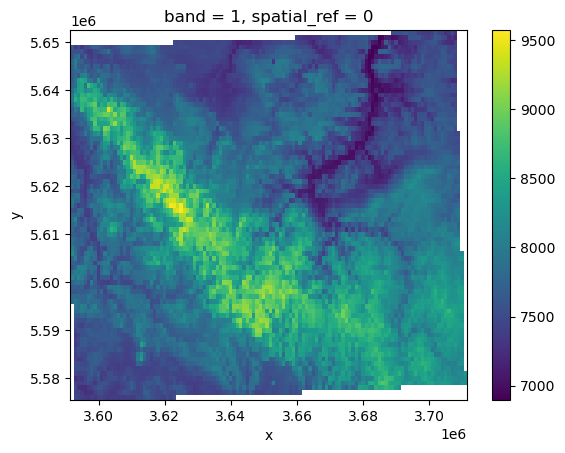

In [8]:
region_box = (ds_soil_moisture.lon < lon_max) & (ds_soil_moisture.lon > lon_min) & (ds_soil_moisture.lat < lat_max) & (ds_soil_moisture.lat > lat_min)
sm_sel = ds_soil_moisture.sum(dim='time').where(region_box).dropna(dim='x', how='all').dropna(dim='y', how='all')
# sm_sel = ds_soil_moisture.sum(dim='time').where(region_box) # dropna to get only te box,otherwise we get a hige, mostly masked map 
sm_sel.plot()

#weird edge because of flat earth/not flat earth thing

Looks pretty similar to the temperature data! but opposite - which could be what is expected?

It differs a bit from the precip data tho, because of the extra band coordinate - get rid of it!

In [9]:
# get rid of the band coord, since irrelevant

ds_soil_moisture = ds_soil_moisture.squeeze('band') # da.squeeze gets rid of all dimension with length 1 :)

In [10]:
sm_no_nan = np.array([ds_soil_moisture.isel(time=i).where(region_box).dropna(dim='x', how='all').
                      dropna(dim='y', how='all').values for i in range(len(ds_soil_moisture.time))])
dim_time, dim_y, dim_x = sm_no_nan.shape # to update the dimension of the dataset
sm_lat_max, sm_lat_min, sm_lon_min, sm_lon_max = sm_sel.lat[-1,0].values, sm_sel.lat[0,0].values, sm_sel.lon[-1,0].values, sm_sel.lon[0,-1].values

In [12]:
# to get a dataset!

sm_reproject = xr.Dataset(
    data_vars= dict(
        sm = (['time', 'lat', 'lon'], sm_no_nan),
    ),
    coords= dict(
        time = ds_soil_moisture.time.values,
        lat = np.linspace(sm_lat_min, sm_lat_max, dim_y),
        lon = np.linspace(sm_lon_min, sm_lon_max, dim_x)
    )
)
sm_reproject

<xarray.Dataset>
Dimensions:  (time: 98, lat: 77, lon: 120)
Coordinates:
  * time     (time) datetime64[ns] 2015-01-31 2015-02-28 ... 2023-02-28
  * lat      (lat) float64 51.0 50.99 50.98 50.97 ... 50.34 50.33 50.32 50.31
  * lon      (lon) float64 10.29 10.3 10.32 10.33 ... 11.96 11.97 11.99 12.0
Data variables:
    sm       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

Amazing, lets save it as a zarr!

In [44]:
sm_reproject.to_zarr('/work/users/my982hzao/soil_moisture_monthly.zarr')

And now lets look around the data:

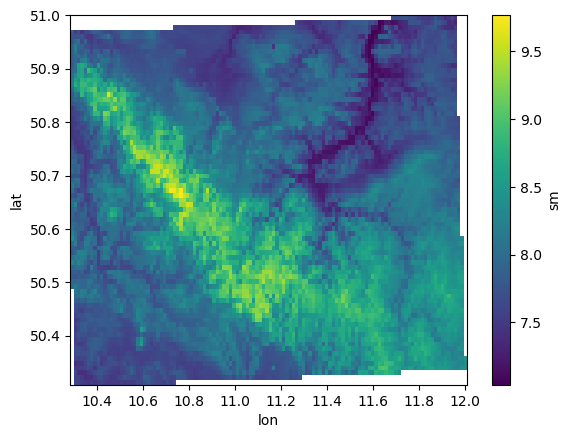

In [13]:
(sm_reproject.sm.mean(dim='time') / 10).plot()

so now lets find out dome more about the soil moisture:

The grid is interpolated from the soil moisture in 60cm depth under grass which was derived at a fixed selection of stations. Only
locations with complete data sets from 1.1.1991 till now (2023) have been used. The soil moisture under grass is calculated by the model
AMBAV, which was developed at the agrometeorological research centre in Braunschweig. The interpolation method is a regional
multiple linear regression with geographical longitude, latitude and height of location as input variables and a subsequent triangulation,
covering Germany with a resolution of 1x1 km.

Values are in percent plant useable water (% NFK), where the used soil has a wilting point of 13 volume%
and a field capacity of 37 volume%.

The grids contain uncertainties concerning calculation and also from interpolation. From nearly 280 locations
360000 grid points were interpolated. As the soil moisture depends strongly on precipitation which has large
spatial variability, the interpolated grids cannot be expected to be exact.

The calculations at the locations were made by the agrometeorological model AMBAV. The interpolation was made in two steps.
Dividing Germany in 20 different regions by overlapping circles and making a multiple linear regression with all locations in each circle.
Regression coefficients are the height, the longitude and latitude of the location. The calculated regression coefficients of the four
surrounding circles for a given location were weighted in dependence from the distance to circle centres. In a last step the differences
between calculated values and the interpolated values at the calculation locations are distributed by a triangulation into the grid. (from the read me for this data)

lets look more into the parameter meaning:

they are percentages of effective field capacity. The effective field capacity (nFK) expresses the volume of water already in the soil and which is available for the plants growing on it. Below a value of 50% nFK, plants must be assumed to suffer water stress. Values of over 100%nFK mean that soils are oversaturated. 

Agro-Meteorological Model for the Assessment of Crop Yield Losses due to Extreme Weather Events = AMBAV

(chatGPT) The AMBAV model uses a combination of weather data, crop growth models, and statistical methods to estimate crop yields at the regional level. The model is designed to be flexible and can be used for a variety of crops, including wheat, barley, corn, and potatoes.

The model takes into account a range of meteorological variables, such as temperature, precipitation, and solar radiation, as well as soil properties and crop-specific parameters, such as planting date and growth stage. The model is calibrated using historical yield data and can be used to generate yield forecasts for different regions and time periods.

The AMBAV model is an example of a crop yield forecasting system, which is an important tool for agriculture planning and risk management.

So this is a bit strange to me, since more agriculturally based than 'natural eco system based'; need to look more into how it works

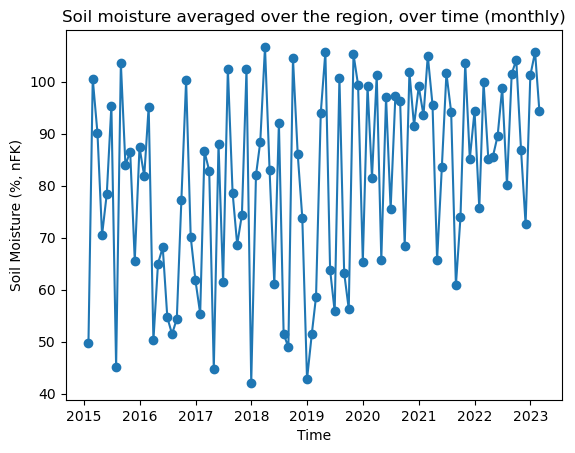

In [38]:
x = sm_reproject.time
y = sm_reproject.sm.mean(dim=('lat', 'lon'))

plt.plot(x, y, marker='o')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (%, nFK)')
plt.title('Soil moisture averaged over the region, over time (monthly)')

plt.show()

lets smooth it a bit and look at it seasonally:

In [39]:
sm_seasonal = sm_reproject.resample(time='QS-DEC').mean()

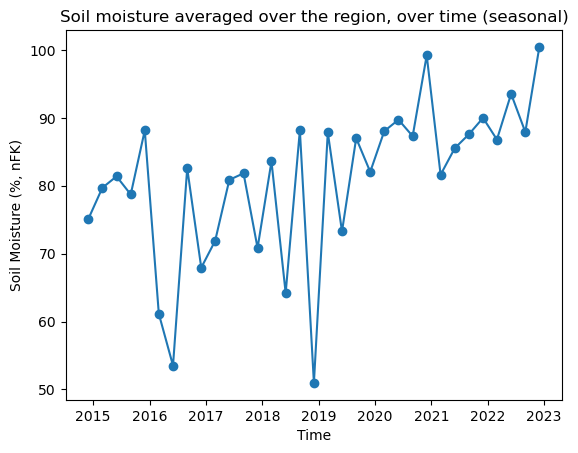

In [40]:
x = sm_seasonal.time
y = sm_seasonal.sm.mean(dim=('lat', 'lon'))

plt.plot(x, y, marker='o')
plt.xlabel('Time')
plt.ylabel('Soil Moisture (%, nFK)')
plt.title('Soil moisture averaged over the region, over time (seasonal)')

plt.show()